In [1]:
import crispr_assembler as ca
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm

%load_ext autoreload
%autoreload 2

import pickle

In [2]:
def process_path(path, cut = -1, save = 1):
    pairs_path = path + "/out/pairs/"
    files = sorted(os.listdir(pairs_path))
    
    print(pairs_path + files[0])
    
    read = ca.Read(pairs_path + files[0])
    read.correct_errors(minimum_occurences=5)
    gr = read.graph_from_pairs()[0]
    
    print('calc embs')
    ec = ca.EmbeddingsCalculator()
    ec.make_argsorts(gr[:cut, :cut])
    embs = ec.fit_predict(gr[:cut, :cut], njobs=32)
    
    if save:
        pickle.dump(read, open(path + "/read", 'wb'))
        np.save(path + "/graph", gr)
        np.save(path + "/embs", embs)
        
    return read, gr, embs

In [3]:
def load(path):
    return pickle.load(open(path + "/read", 'rb')), np.load(path + "/graph.npy"), np.load(path + "/embs.npy")

In [4]:
def unwrap_idx_to_spacer(idx_to_spacer):
    values_as_list = []
    for i in range(len(idx_to_spacer)):
        values_as_list.append(idx_to_spacer[i])
    return values_as_list

In [5]:
def continue_steps(reads, pointers):
    return any([pointers[i] < len(reads[i]) for i in range(len(reads))])

In [6]:
def merge_reads(reads, t=1, v = 1):
    spacers_lists = [unwrap_idx_to_spacer(x) for x in reads]#[unwrap_idx_to_spacer(x.index_to_cluster) for x in reads]
    pointers = [0 for i in range(len(reads))]
    merged_sp_to_idxes = {}
    old_idx_to_new_idx = [{} for i in range(len(reads))]
    
    curr = 0
    while continue_steps(spacers_lists, pointers):
        for i in range(len(reads)):
            if pointers[i] < len(reads[i]):
                spacer = spacers_lists[i][pointers[i]]
                
                dist, closest = ca.find_closest(merged_sp_to_idxes, spacer)
                if dist > t:
                    merged_sp_to_idxes[spacer] = curr
                    #new_sp_to_ids[i][spacer] = curr
                    old_idx_to_new_idx[i][pointers[i]] = curr
                    curr += 1
                else:
                    old_idx_to_new_idx[i][pointers[i]] = merged_sp_to_idxes[closest]
                
                pointers[i] += 1
                
                if curr % 100 == 0:
                    print(curr)
                

                if v:
                    print(i, pointers[i], spacer, dist, merged_sp_to_idxes)#, new_sp_to_ids[1])
                    
    return merged_sp_to_idxes,  old_idx_to_new_idx

In [7]:
def rearange(gr, order):
    new_gr = np.zeros((max(order.values()) + 1, max(order.values()) + 1))

    for i in tqdm.tqdm(range(len(order.keys()))):
        for j in range(len(order.keys())):
            new_gr[order[i], order[j]] = gr[i, j]

    return new_gr

In [8]:
paths = [
    '/home/rykachevskiy/CRISPR_research/data/environmental/s1/',
    '/home/rykachevskiy/CRISPR_research/data/environmental/s2/',
    '/home/rykachevskiy/CRISPR_research/data/environmental/s3/'
]



In [9]:
res_all = [process_path(x) for x in paths]

FileNotFoundError: [Errno 2] No such file or directory: '/home/rykachevskiy/CRISPR_research/data/environmental/s1//out/pairs/'

In [11]:
reads = [x[0] for x in res_all]
grs = [x[1] for x in res_all]
embs = [x[2] for x in res_all]

In [9]:
gr = np.load("/home/anton/Downloads/graph(2).npy")

In [10]:
read = pickle.load(open("/home/anton/Downloads/read(1)", 'rb'))

In [11]:
ec = ca.EmbeddingsCalculator()
embs = ec.fit_predict(gr)

In [12]:
#answer_sensivity = ca.read_arrays_with_tags("../../article/data/answers/sensivity", 0)
answer = ca.read_arrays_with_tags("../../article/data/answers/all", 0)

In [13]:
a, d = ca.multiple_arrays_to_ids(answer, read.spacer_to_cluster_index)

#a_all, d_all = ca.multiple_arrays_to_ids(answer_all, res.spacer_to_cluster_index)

answ_gr = ca.graph_from_arrays([x for x in a.values()], gr.shape[0])[0]

100%|██████████| 54/54 [00:01<00:00, 31.32it/s]


In [14]:
arrays_found_d = []
for k,v in d.items():
    if max(sorted(v)[::-1][2:]) < 3:
        arrays_found_d.append(k)

In [15]:
arrays_found_v = []
for k,v in a.items():
    #print(k, sorted(v)[::-1])
    if max(sorted(v)[::-1][1:]) < 300:
        arrays_found_v.append(k)

In [17]:
set(arrays_found_v).intersection(set(arrays_found_d))

{'first_12',
 'first_19',
 'first_2',
 'first_20',
 'first_22',
 'first_24',
 'first_31',
 'first_61',
 'first_62',
 'first_66',
 'first_68',
 'first_8',
 'first_9',
 'second_1',
 'second_11',
 'second_14',
 'second_5',
 'second_50',
 'second_67'}

In [50]:
(answ_gr[:cut, :cut] > 0).sum()

27

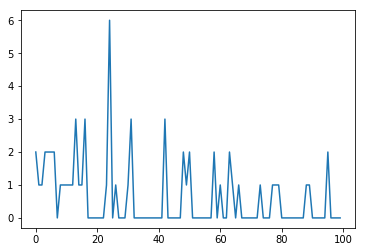

In [49]:
plt.plot((answ_gr > 0).sum(1)[:100])

In [52]:
answ_gr.shape

(656, 656)

In [53]:
gr.shape

(656, 656)

In [64]:
gr[cut1:cut2, cut1:cut2].max()

7

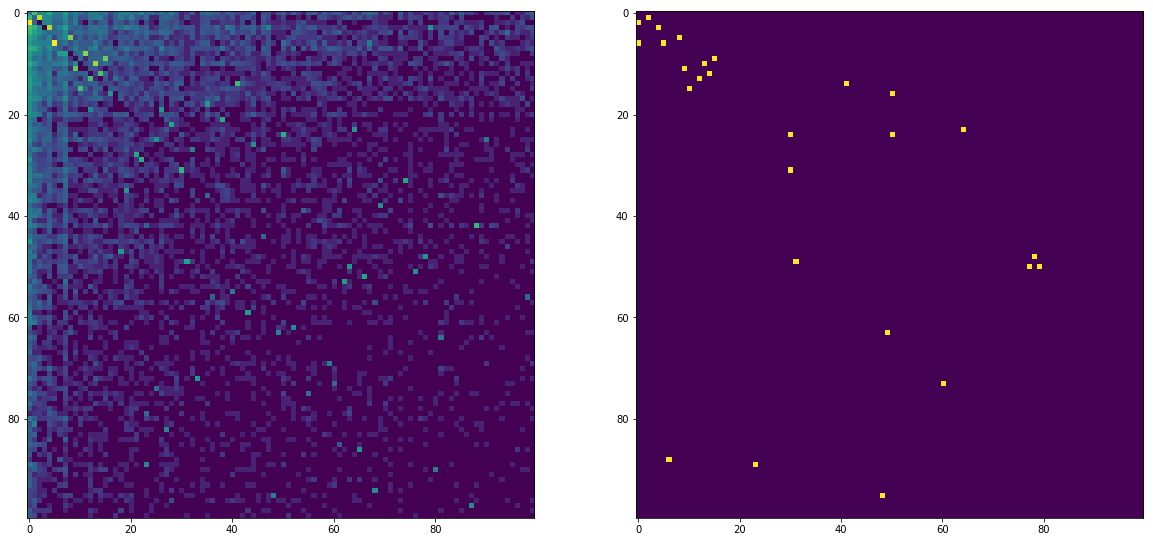

In [20]:
cut1 = 0
cut2 = 100
ca.plot_grs(gr[cut1:cut2, cut1:cut2],
           (answ_gr[cut1:cut2, cut1:cut2] > 0).astype(int),
#             grs_m[1][:cut, :cut],
#             grs_m[2][:cut, :cut],
            log = 1, 
            s = 20)
plt.show()

In [38]:
gb = pickle.load(open("../article/linear_svc_rep_to_rep", 'rb'))

#pred = gb.predict(embs[0]).reshape((grs[0].shape[0] - 1, grs[0].shape[1] - 1))

In [40]:
pred = gb.predict(embs[1]).reshape((grs[1].shape[0] - 1, grs[1].shape[1] - 1))

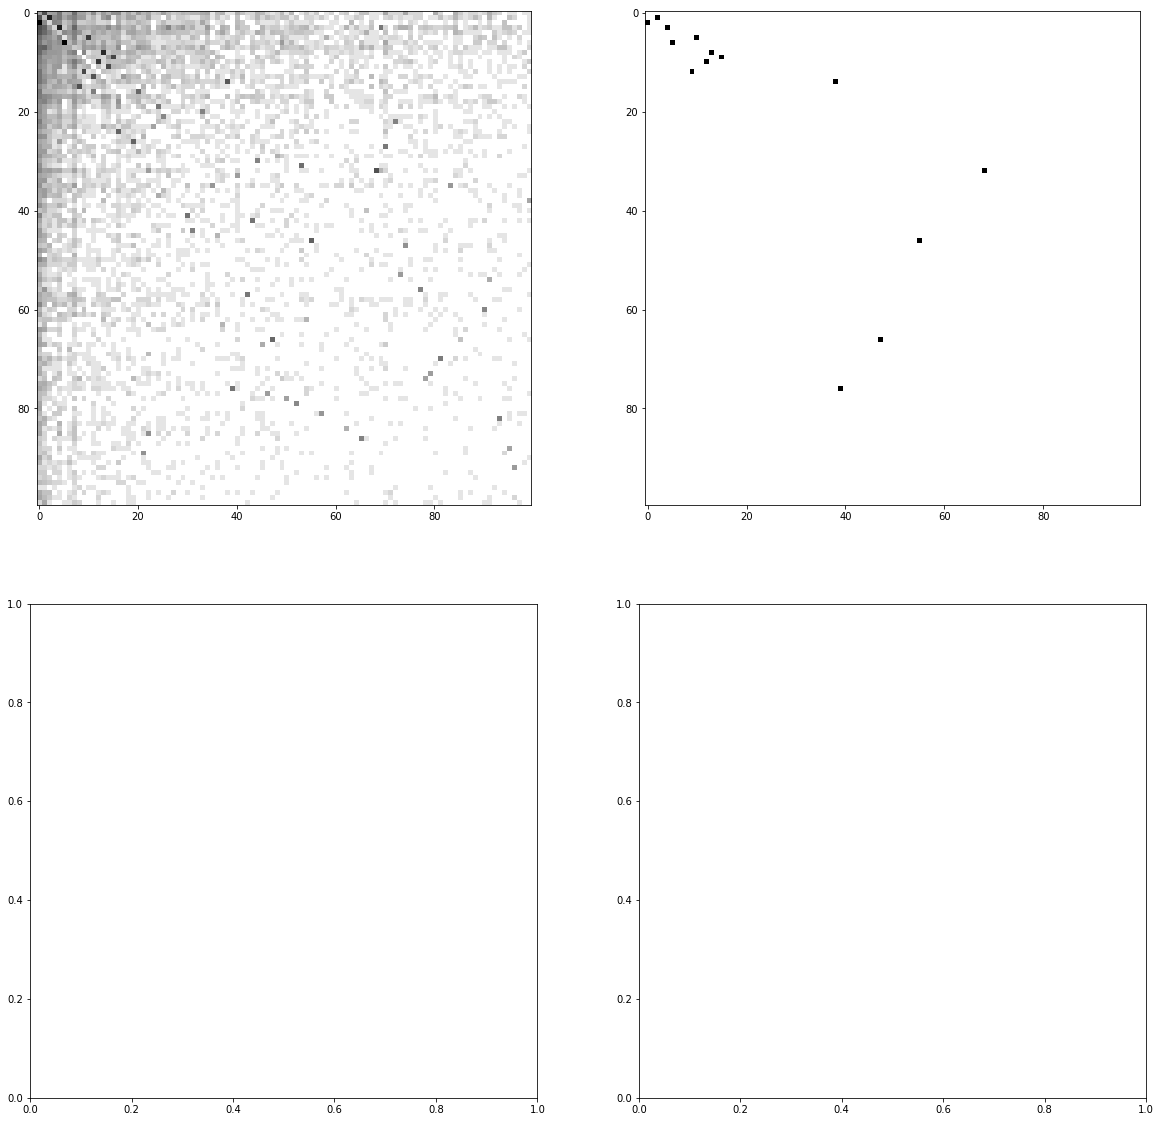

In [41]:
# cut = 100
ca.plot_grs(grs[1][:cut, :cut],
            pred[:cut, :cut],
            log = 1, 
            s = 20, subplots_form = (2,2))
plt.show()

In [20]:
grs_m[1][2].astype(int)[:10]

array([ 90,  32,   5,  21, 332,   9,  19,  28,  10,  13])

In [22]:
grs_m[2][2].astype(int)[:20]

array([ 95,  22,   7,  26, 471,  11,  11,  29,  10,   4,   6,   5,  15,
        13,   5,  14,  17,   8,   2,  20])

## SlV

In [26]:
slv_read, slv_gr, slv_embs = load("/home/rykachevskiy/CRISPR_research/data/environmental/slv2/")

In [27]:
merged_vo, old_to_new_vo = merge_reads([x.index_to_cluster for x in [slv_read, reads[1]]], t = 5, v = 0)

100
200
200
200
300
400
500
600
600


In [28]:
slv_gr_vo = rearange(slv_gr,old_to_new_vo[0])
slo_gr_vo = rearange(grs[1],old_to_new_vo[1])

100%|██████████| 605/605 [00:00<00:00, 5109.67it/s]


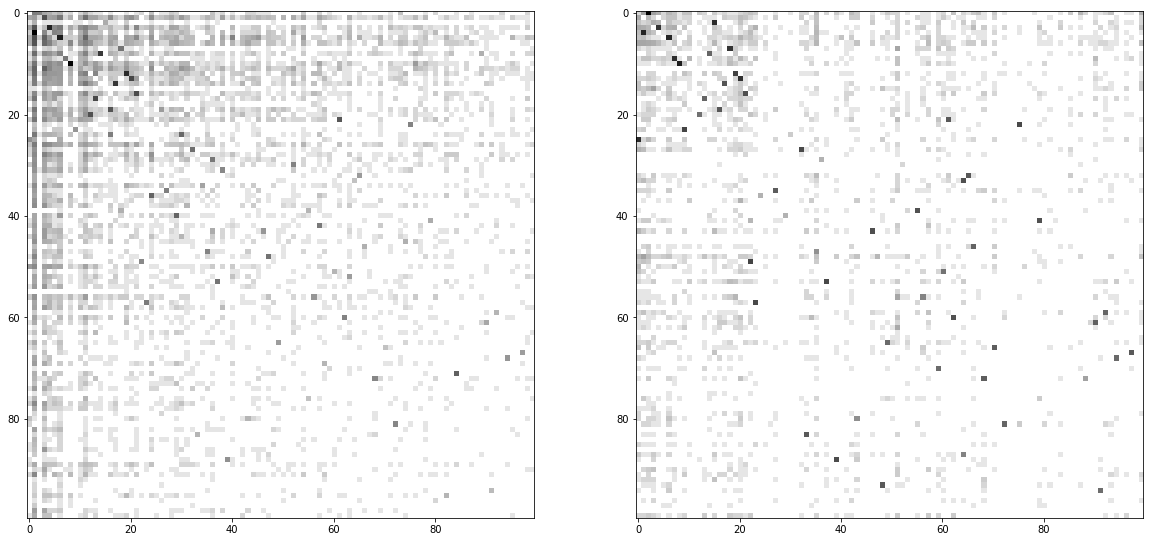

In [30]:
ca.plot_grs(slo_gr_vo[:cut, :cut],
         slv_gr_vo[:cut, :cut],
         log =1,
         s = 20
        )

### graphs

In [65]:
'/home/rykachevskiy/CRISPR_research/data/environmental/s3/out/pairs/SlO3_ATTCCT_L001_R1_001.fastq.gz_pairs.txt'

'/home/rykachevskiy/CRISPR_research/data/environmental/s3/out/pairs/SlO3_ATTCCT_L001_R1_001.fastq.gz_pairs.txt'

In [66]:
# reads =  [ca.Read(paths[0] + "pairs/SlO2_ACTGAT_L001_R1_001.fastq.gz_pairs.txt"),
#           ca.Read(paths[1] + "pairs/SlO3_ATTCCT_L001_R1_001.fastq.gz_pairs.txt")]

read = ca.Read(path)

In [67]:
len(read.contigs)

740835

In [68]:
read.correct_errors(minimum_occurences=5)

100%|██████████| 1226/1226 [00:00<00:00, 4092.13it/s]


In [69]:
gr = read.graph_from_pairs()[0]

In [70]:
gr.shape

(221, 221)

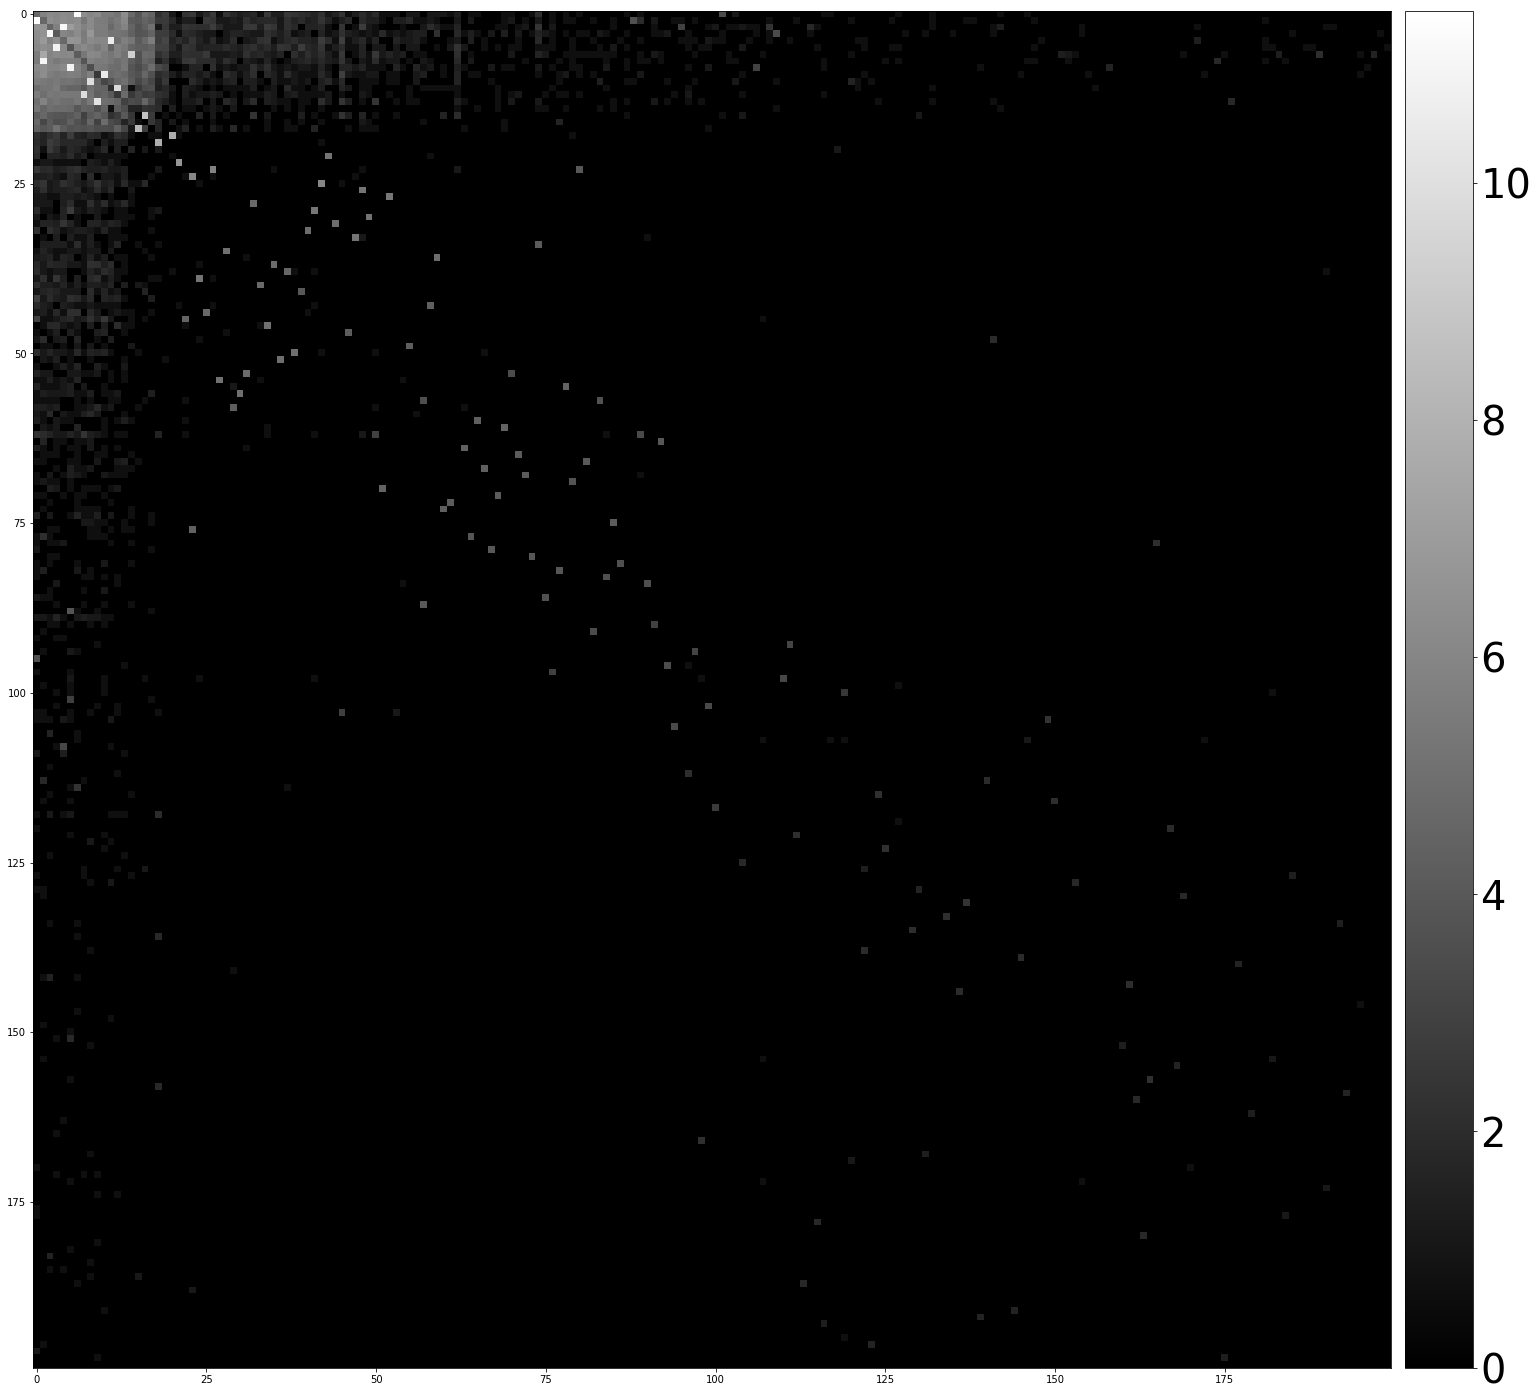

In [71]:
ca.plot_gr(gr[:200, :200], log =1)
plt.show()

In [10]:
grs = [x.graph_from_pairs()[0] for x in reads]

In [11]:
np.save(paths[0] + "graph", grs[0])
np.save(paths[1] + "graph", grs[1])

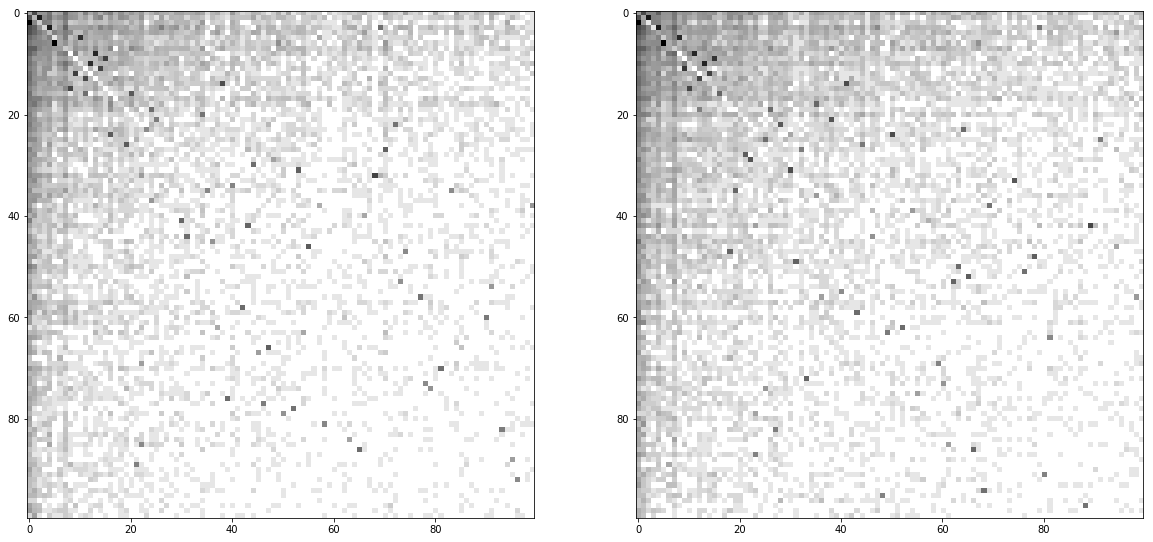

In [18]:
cut = 100
ca.plot_grs(grs[0][:100, :100], grs[1][:100, :100], log = 1, s=20)
plt.show()

In [17]:
[x.shape for x in grs]

[(2829, 2829), (3635, 3635)]

## Merge reads

In [34]:
def unwrap_idx_to_spacer(idx_to_spacer):
    values_as_list = []
    for i in range(len(idx_to_spacer)):
        values_as_list.append(idx_to_spacer[i])
    return values_as_list

In [35]:
d1 = {1 : 'AAA', 2 : 'CCC'}
d2 = {1 : 'AAB', 2: 'GGT', 3 : 'CCC'}

In [28]:
def merge_reads(reads):
    pointers = [0 for i in range(len(reads))]
    merged_sp_to_idxes = [{} for i in range(len(reads))]
    
    curr = 0
    while continue_steps(reads, pointers):
        for i in range(len(reads)):
            if pointer[i] < len(reads[i].spacer_to_index):
                dist, closest = ca.find_closest(merged_sp_to_idxes, )
    

SyntaxError: invalid syntax (<ipython-input-28-22cf7978d4c7>, line 7)

In [20]:
r = reads[0]

In [25]:
r.corrector.spacers_to_occurrences

OrderedDict([('ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC', 3594),
             ('TGGCTCTGCAACAGCAGCACCCATGACCACGT', 2411),
             ('GAAATGCTGGTGAGCGTTAATGCCGCAAACAC', 2368),
             ('GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC', 1905),
             ('CTGTTTTCGCAAATCTATGGACTATTGCTATT', 1833),
             ('GTAGTCCATCATTCCACCTATGTCTGAACTCC', 1555),
             ('TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG', 1543),
             ('CAATCTGGGCGACCGGTCATCATCGCTTCGATG', 1210),
             ('GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG', 934),
             ('AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC', 884),
             ('CCGGGGGATAATGTTTACGGTCATGCGCCCCC', 870),
             ('TCAACATTATCAATTACAACCGACAGGGAGCC', 833),
             ('TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG', 831),
             ('GCGACCGCTCAGAAATTCCAGACCCGATCCAAA', 823),
             ('AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG', 767),
             ('TAGTTTCCGTATCTCCGGATTTATAAAGCTGA', 666),
             ('CTGCTGCTCGAGCTGGTGGAGTGCTGCTATAG', 663),
             ('CAGAACATACTTCAAAGCCCGA

In [26]:
reads[1].corrector.spacers_to_occurrences

OrderedDict([('ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC', 4581),
             ('TGGCTCTGCAACAGCAGCACCCATGACCACGT', 2858),
             ('GAAATGCTGGTGAGCGTTAATGCCGCAAACAC', 2849),
             ('GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC', 2166),
             ('CTGTTTTCGCAAATCTATGGACTATTGCTATT', 2150),
             ('GTAGTCCATCATTCCACCTATGTCTGAACTCC', 2001),
             ('TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG', 1850),
             ('CAATCTGGGCGACCGGTCATCATCGCTTCGATG', 1488),
             ('CCGGGGGATAATGTTTACGGTCATGCGCCCCC', 1254),
             ('AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC', 1213),
             ('GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG', 1205),
             ('TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG', 1119),
             ('TCAACATTATCAATTACAACCGACAGGGAGCC', 1072),
             ('GCGACCGCTCAGAAATTCCAGACCCGATCCAAA', 1062),
             ('AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG', 1042),
             ('TAGTTTCCGTATCTCCGGATTTATAAAGCTGA', 940),
             ('GCGGGCGTTAACGCGGTGATACTGTTTGACGG', 717),
             ('CAGAACATACTTCAA

In [27]:
r.spacer_to_cluster_index

{'ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC': 0,
 'TGGCTCTGCAACAGCAGCACCCATGACCACGT': 1,
 'GAAATGCTGGTGAGCGTTAATGCCGCAAACAC': 2,
 'GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC': 3,
 'CTGTTTTCGCAAATCTATGGACTATTGCTATT': 4,
 'GTAGTCCATCATTCCACCTATGTCTGAACTCC': 5,
 'TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG': 6,
 'CAATCTGGGCGACCGGTCATCATCGCTTCGATG': 7,
 'GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG': 8,
 'AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC': 9,
 'CCGGGGGATAATGTTTACGGTCATGCGCCCCC': 10,
 'TCAACATTATCAATTACAACCGACAGGGAGCC': 11,
 'TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG': 12,
 'GCGACCGCTCAGAAATTCCAGACCCGATCCAAA': 13,
 'AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG': 14,
 'TAGTTTCCGTATCTCCGGATTTATAAAGCTGA': 15,
 'CTGCTGCTCGAGCTGGTGGAGTGCTGCTATAG': 16,
 'CAGAACATACTTCAAAGCCCGAGGCGTACACG': 17,
 'TAGGCCTATAGAGACGAGCGTTCGTTAAAGCA': 18,
 'ATAGACCCCGAACAACAATACGCGCAAACCGA': 19,
 'AACGTCAGGTTGTCGCCGCTCTGCGTGGTCGC': 20,
 'GATCAGATAAATGGCGAGACGATCCTGTTGCAC': 21,
 'AGTGCTGGACCATTTCAAATTCACAATAGATT': 22,
 'GCGGGCGTTAACGCGGTGATACTGTTTGACGG': 23,
 'TACCGTACAGACTGCCGGAT

### embs

In [40]:
ec =ca.EmbeddingsCalculator()
ec.make_argsorts(gr[:cut, :cut])
embs = ec.fit_predict(gr[:cut, :cut], njobs=32)

In [41]:
embs = ec.fit_predict(gr[:cut, :cut], njobs=32)

In [17]:
#embs = np.load("../../../Ecoli_env/m2/out/embs.npy")
np.save("/home/rykachevskiy/CRISPR_research/data/environmental/c2/out/embs", embs)


In [15]:
path

'/home/rykachevskiy/CRISPR_research/data/environmental/c2/out/pairs/cat2_L001_R1_001.fastq.gz_pairs.txt'

In [42]:
gb = pickle.load(open("./gb_rep_to_rep", 'rb'))

In [44]:
preds = gb.predict_proba(embs)[:,1].reshape(gr[:cut, :cut].shape)

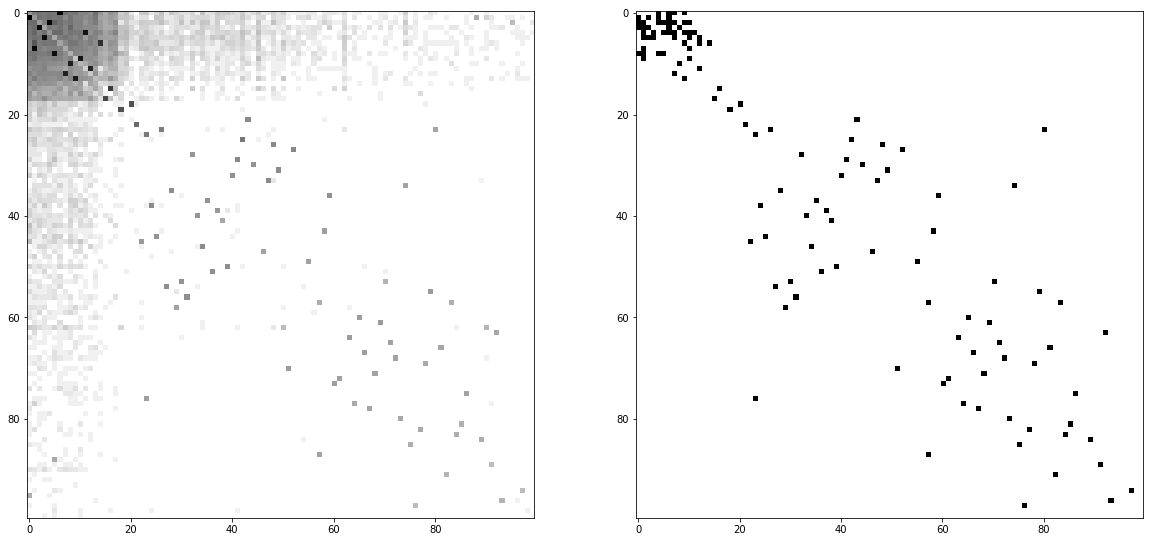

In [45]:
cut = 100
ca.plot_grs(gr[:cut,:cut], preds[:cut,:cut] > 0.5, log =1, s = 20)

In [62]:
np.where(gr.max(1) == 26)

(array([497]),)

In [64]:
gr[1]

array([94733,   101,   587,   458,   554,   482,   541,   211,   504,
         266,   258,   164,   243,   447,    62,    53,    84,    63,
          12,    13,     6,     1,     3,     3,     0,    12,    11,
           2,     2,     4,     8,     2,     4,     5,     5,     5,
           2,     8,     6,     4,     3,     4,    11,     4,     1,
           4,     5,     0,     5,     3,     3,     1,     0,     3,
           3,     5,     1,     1,     3,     1,     0,     0,     2,
           0,     2,     0,     0,     1,     0,     1,     2,     0,
           1,     0,     3,     0,     1,     0,     1,     1,     0,
           0,     1,     0,     0,     0,     1,     0,    39,     0,
           6,     2,     0,     0,     1,     1,     0,     1,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     1,
           0,     0,     0,     0,     1,     0,     0,     0,     0,
           0,     0,     0,     2,     0,     0,     0,     0,     1,
           0,     0,

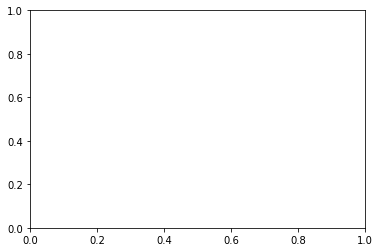

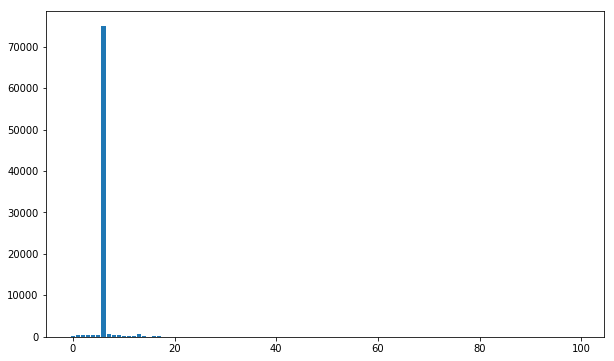

In [48]:
plt.figure(figsize = (10, 6))
plt.bar(np.arange(cut), gr[0][:cut] + 1)
plt.show()

In [24]:
gr[0]

array([   91,   409,   389,   367,   389,   468,   458, 65513,   738,
         519,   250,   234,   185,   652,    96,   248,    59,   168,
           4,     7,    16,     3,     7,    21,    10,    14,     6,
          23,    26,    15,    11,    11,    11,     8,    26,    10,
          11,    16,    19,    12,     7,    12,    10,     2,    10,
           1,     2,     4,     3,     3,    12,     2,     0,     1,
           3,     3,     1,     1,     0,     1,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     2,     0,     1,
           0,     0,     1,     0,     1,     2,     0,     3,     0,
           0,     1,     1,     2,     2,     2,     0,     1,     0,
           0,     0,     0,     1,     0,     0,     3,     2,     0,
           0,     0,     1,     1,     0,     2,     1,     0,     0,
           0,     1,     1,     0,     0,     1,     0,     0,     0,
           1,     0,     0,     0,     0,    17,     0,     1,     1,
           0,     0,

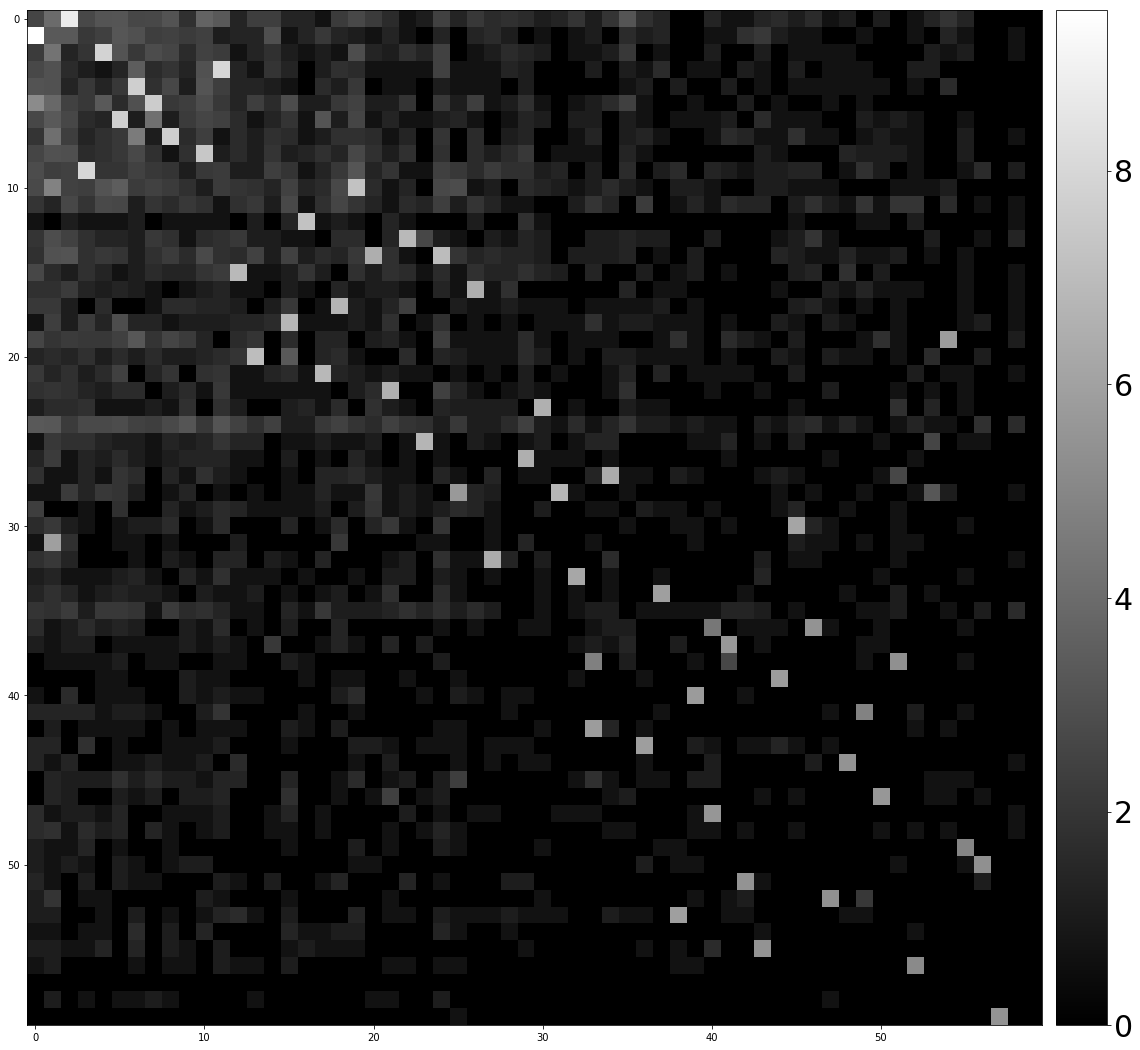

In [34]:
cut = 60
ca.plot_gr(gr[:cut,:cut], log = 1, s = 30, save_path="./slo", all_ticks=0)
plt.show()

In [29]:
def get_top_stats(graph, i, cut=10, axis=0):
    return np.array(sorted(graph[i])[::-1][:10]), np.argsort(graph[i])[::-1][:10]

In [35]:
get_top_stats(gr, 28)

(array([877, 292,  79,  25,  13,   8,   7,   7,   7,   6]),
 array([ 31,  25,  74,  53, 242,   2,   4,  20, 190,   5]))

In [37]:
get_top_stats(preds, 28)

(array([  9.99639410e-01,   2.77795110e-01,   6.13370253e-02,
          2.40353250e-03,   1.60886381e-03,   1.60886381e-03,
          2.82336667e-04,   1.58908208e-04,   1.58908208e-04,
          1.58908208e-04]),
 array([ 31,  25,  74, 242, 493, 190,  53,   6,  18,  49]))

In [38]:
preds[28, 53]

0.00028233666681546548

In [40]:
embs_sq = embs.reshape(gr.shape[0], gr.shape[1], 6)

In [41]:
embs_sq[28][31]

array([ 1.        ,  1.        ,  0.63781818,  0.95016251,  6.77764659,
        6.77764659])

In [42]:
embs_sq[28][25]

array([ 0.99960815,  1.        ,  0.21236364,  0.64317181,  5.68017261,
        5.68017261])

In [50]:
for v, i in zip(*get_top_stats(preds, 28)):
    print(v, embs_sq[28][i])

0.999639409933 [ 1.          1.          0.63781818  0.95016251  6.77764659  6.77764659]
0.277795109973 [ 0.99960815  1.          0.21236364  0.64317181  5.68017261  5.68017261]
0.0613370252526 [ 0.9992163   1.          0.05745455  0.76699029  4.38202663  4.38202663]
0.00240353249703 [ 0.9984326   1.          0.00945455  1.          2.63905733  2.63905733]
0.00160886381019 [ 0.9960815   1.          0.00363636  0.83333333  1.79175947  1.79175947]
0.00160886381019 [ 0.9968652   1.          0.00509091  0.77777778  2.07944154  2.07944154]
0.000282336666815 [ 0.99882445  1.          0.01818182  0.3968254   3.25809654  3.25809654]
0.000158908207799 [  9.92554859e-01   9.79623824e-01   1.45454545e-03   7.51314801e-04
   1.09861229e+00   1.09861229e+00]
0.000158908207799 [  9.86285266e-01   9.61990596e-01   7.27272727e-04   9.17431193e-04
   6.93147181e-01   6.93147181e-01]
0.000158908207799 [  9.90987461e-01   9.93730408e-01   7.27272727e-04   2.90697674e-03
   6.93147181e-01   6.93147181e-01

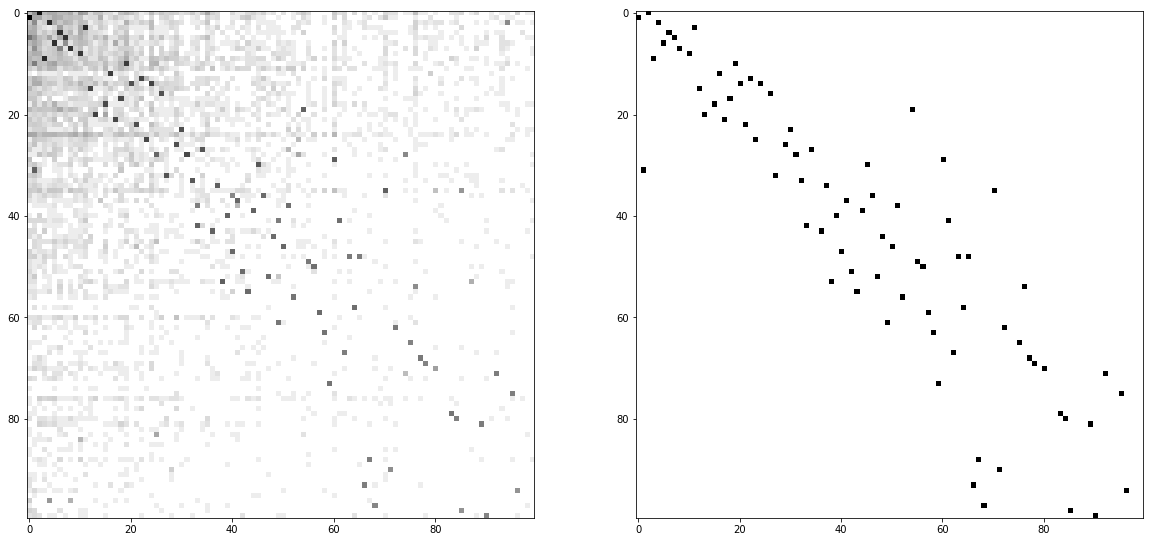

In [23]:
cut = 100
ca.plot_grs(gr[:cut, :cut], preds[:cut, :cut], s = 20, log = 1)

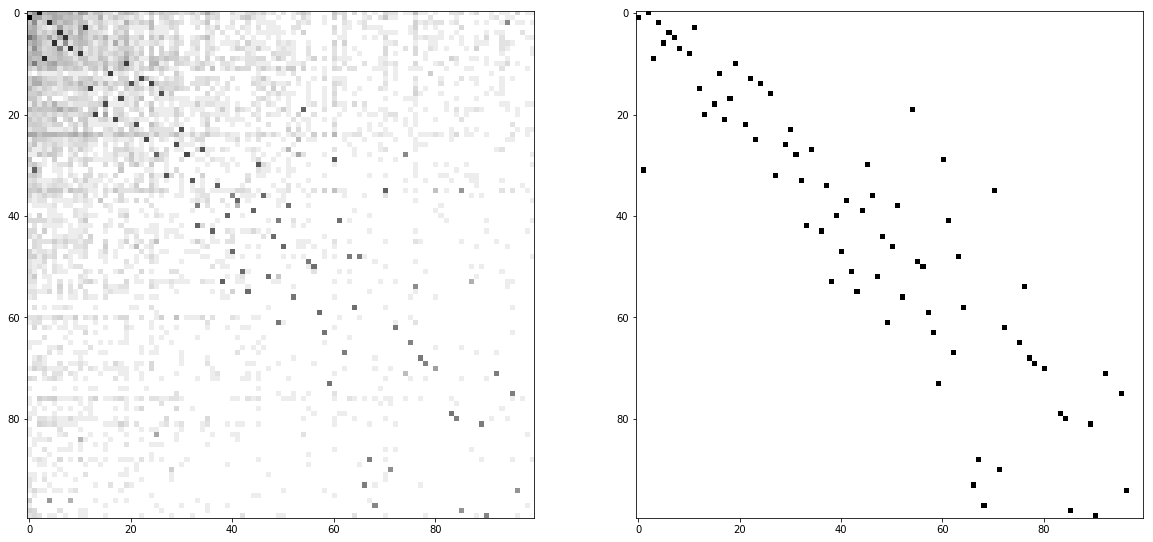

In [12]:
cut = 100
ca.plot_grs(gr[:cut, :cut], gr_restored[:cut, :cut], s = 20, log = 1)

In [10]:
def calc_noise_ratio(gr0, gr):
    return 1 - gr[gr0>0].sum() / gr.sum(), ((gr > 0).sum() - (gr0 > 0).sum()) / gr.flatten().shape[0]

In [6]:
arrs, weights = ca.restore_arrays_greedy(gr, threashold=2)

In [7]:
gr_restored = ca.graph_from_arrays(arrs, gr.shape[0])[0]

In [13]:
len([x for x in arrs if len(x) > 3])

46

In [43]:
calc_noise_ratio(gr_restored[:500, :500], gr[:500, :500])

(0.15619127416362444, 0.020043999999999999)

In [44]:
calc_noise_ratio(gr_restored[:100, :100], gr[:100,:100])

(0.13019157400241677, 0.27779999999999999)

# cut gr

In [24]:
ec =ca.EmbeddingsCalculator()
ec.make_argsorts(gr[:100,:100])

In [25]:
embs2 = ec.build_embeddings(gr[:100,:100])

Process ForkPoolWorker-32:
Process ForkPoolWorker-26:
Process ForkPoolWorker-30:
Process ForkPoolWorker-31:
Process ForkPoolWorker-28:
Traceback (most recent call last):
Process ForkPoolWorker-27:
Traceback (most recent call last):
Process ForkPoolWorker-29:
Traceback (most recent call last):
Process ForkPoolWorker-25:
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.

In [26]:
preds2 = gb.predict(embs2).reshape(gr[:100,:100].shape)

In [30]:
embs2_sq = embs2.reshape(100,100, -1)

In [51]:
embs_sq = embs.reshape(gr.shape[0], gr.shape[1], -1)

In [52]:
gb.predict_proba(embs_sq[2, 5].reshape(1,-1))

array([[0.61947113, 0.38052887]])

In [66]:
gb.predict_proba(embs2_sq[2, 5].reshape(1,-1))

array([[0.99736337, 0.00263663]])

In [54]:
embs_sq[2, 5]

array([1.        , 1.        , 0.28552368, 0.29215017, 6.06145692,
       6.06145692])

In [55]:
gb.predict_proba([[1., 1., 0.28552368, 0.29215017, 6.06145692, 6.06145692]])

array([[0.61947113, 0.38052887]])

In [57]:
gr[2][:10]

array([ 53,  98,   7,  54,  30, 428,  28,  12,  17,  19])

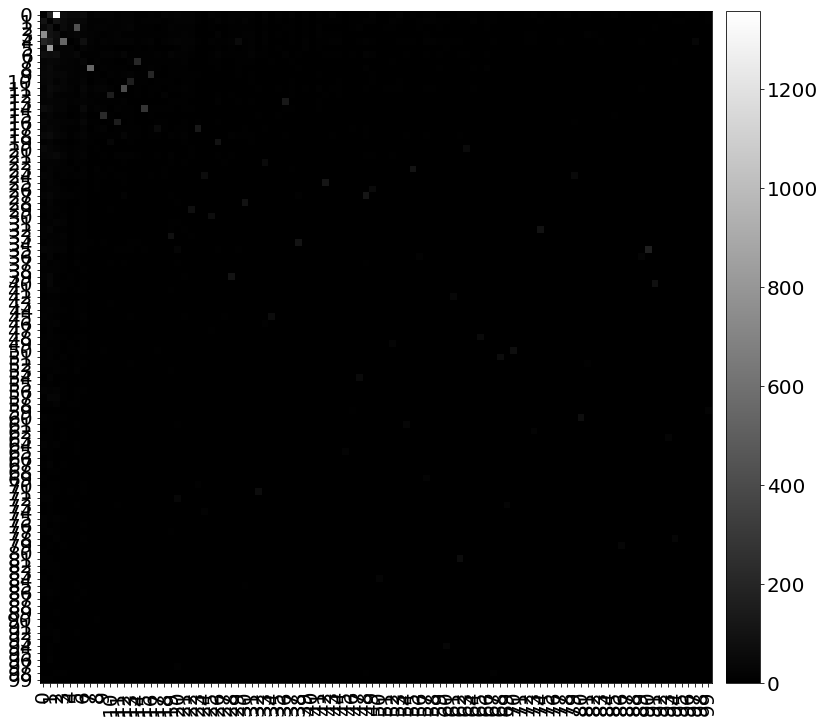

In [72]:
ca.plot_gr(gr[:100, :100], s = 20, all_ticks=1)

In [ ]:
2 5 1 

In [70]:
get_top_stats(gr, 2)

(array([428,  98,  54,  53,  30,  28,  24,  19,  18,  17]),
 array([ 5,  1,  3,  0,  4,  6, 13,  9, 12,  8]))

In [68]:
gr[1].sum()

1758

In [69]:
gr[:, 1].sum()

3733

In [ ]:
0

In [27]:
gr.shape

(2165, 2165)

In [6]:
cut = 100
ca.plot_grs(gr[:cut, :cut], preds2[:cut, :cut], s = 20, log = 1)

NameError: name 'preds2' is not defined

In [52]:
read =  ca.Read("../../data/SlO_10/SlO2_R1_pairs_10.txt")

In [55]:
read.correct_errors()

100%|██████████| 15890/15890 [00:44<00:00, 354.66it/s]


In [56]:
gr2 = read.graph_from_pairs()[0]

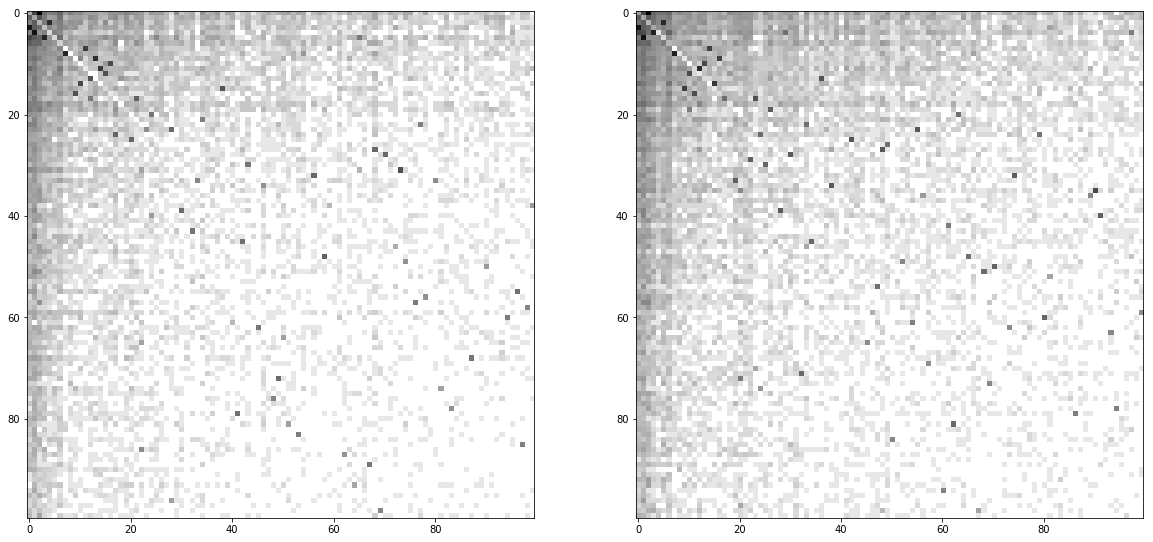

In [69]:
ca.plot_grs(gr2[:100, :100], gr[:100, :100], log = 1, s = 20)

In [81]:
def calc_noise_ratio(gr0, gr):
    return gr[gr0 > 0].sum() / (gr.sum() - gr[gr0 > 0].sum())

In [71]:
arrs, weights = ca.restore_arrays(gr)

In [72]:
restored_gr = ca.graph_from_arrays(arrs, gr.shape[0])[0]

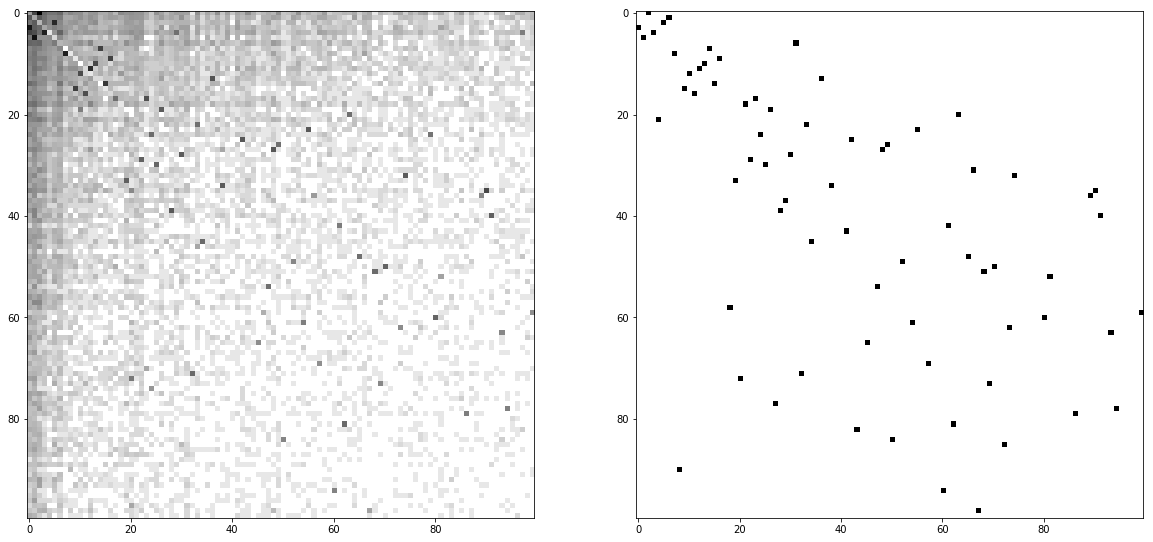

In [73]:
ca.plot_grs(gr[:100, :100], restored_gr[:100, :100], log = 1, s = 20)

In [79]:
gr[:10, :10]

array([[  15,  178, 1357,   73,   48,   48,   64,   18,   28,   22],
       [ 105,   11,  102,   57,   32,   32,   39,   11,   11,   15],
       [  53,   98,    7,   54,   30,  428,   28,   12,   17,   19],
       [ 748,   96,   69,   11,   23,   37,   25,   17,   14,    8],
       [ 200,  147,   60,  541,    1,   21,   80,   21,    9,   17],
       [  47,  840,   22,   22,   25,    2,   26,   11,    7,    8],
       [  77,   68,   77,   25,   23,   41,    7,    9,   10,   16],
       [  29,   42,   35,   24,   17,   14,   28,    0,   13,    7],
       [  33,   51,   23,   20,   16,   13,   14,  536,    1,   11],
       [  38,   46,   34,   35,   18,   11,   19,    8,   11,    1]])

In [82]:
calc_noise_ratio(restored_gr, gr)

0.29165781710914457

# PCA

In [52]:
from sklearn.decomposition import PCA

In [54]:
pca = PCA(2)

In [55]:
pca.fit(embs)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [57]:
embs_2 =pca.transform(embs)

In [61]:
embs_2_cut =embs_2.reshape(gr.shape[0], gr.shape[1], 2)[:100, :100].reshape(10000, 2)

In [66]:
mask = (preds > 0.3)[:100, :100].reshape(10000)

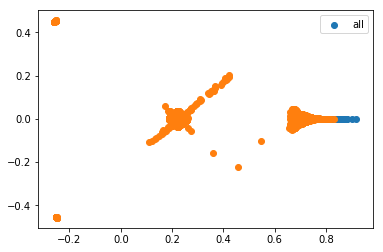

In [68]:
plt.scatter(embs_2_cut[mask, 0], embs_2_cut[mask, 1], label = 'all')
plt.scatter(embs_2_cut[np.logical_not(mask), 0], embs_2_cut[np.logical_not(mask), 1])
plt.legend()
plt.show()